In [1]:
import numpy as np
import pandas as pd
from scipy.integrate import odeint
import matplotlib.pyplot as plt
plt.rcParams["text.usetex"] = True
from numpy import trapezoid

In [2]:

params0 = {
    # Demography
    'pi': 1710,
    'mu': 1/(83*365),

    # Progression
    'eps': 0.33,
    'rho': 1/14,
    'rhoh': 1/10,
    'a': 1/3,
    'a1': 0.5,
    'phi': 1/180,

    # Transmission
    'beta1': 0.17,
    'beta2': 0.66,

    # Testing / vaccination
    'tau': 0.8,
    'Tmax': 0.8,
    'T10': 0.2,
    'T20': 0.2,
    'Fmax': 0.027,
    'F10': 0.0023,
    'F20': 0.002,
    'xi':  0.99, 

    # Behavior
    'D': 50,
    'B': 100,
    'theta': 0.5,
    'alpha1': 0.5,
    'alpha2': 0.5,
    'k1': 0.52,

    # Isolation
    'delta': 0.8,

    # Severity
    'h1': 0.0045,
    'h2': (1-0.74)*0.0045,
    'd1': 0.000034,
    'd2': 0.00031,

    # Immunity
    'eta1': 0.71,
    'eta2': 0.41,
    'eta3': 0.46,
    'eta4': 0.85,

    # Population
    'S2_0': 40000000,
    'E2_0':352645
}

In [3]:
# Initial conditions
NN = 51815808
V2_0 = 2891 
V1_0 = 431 
#E2_0 = 352645 #int(0.87*20*NewCases.iloc[0])
A2_0 = 70529 
I2_0 = 35264 
IT2_0 = 2026
#E1_0 = 52694  
A1_0 = 10538 
I1_0 = 5269 
IT1_0 = 2634 
IU1_0 = 0
IU2_0 = 0
H_0 = 202  # ICU
R_0 = 200
Dth_0 = 15

MV_0 = params0['k1']*((IT1_0 + IT2_0 + H_0)/NN)
MN_0 = params0['k1']*((H_0 + params0['d1']*(IU1_0 + IU2_0) + params0['d2']*H_0)/NN)


In [4]:
def deriv(x, t, p):

    (S1, S2, S3, V1, V2,E1, E2, A1, A2,I1, I2, IT1, IT2,IU1, IU2, H, R, Dth,MV, MN) = x

    dx = np.zeros(20)

    # Total population
    N = (S1 + S2 + S3 + V1 + V2 + E1 + E2 + A1 + A2 + I1 + I2 + IT1 + IT2 + IU1 + IU2 + H + R)

    # -----------------------------
    # Behavioral response functions
    # -----------------------------
    T1 = p['T10'] + (p['Tmax'] - p['T10']) * (p['alpha1'] * (p['D'] * MV) / (1 + p['D'] * MV) + (1 - p['alpha1']) * (p['B'] * MN) /
        (1 + p['B'] * MN))

    F1 = p['F10'] + (p['Fmax'] - p['F10']) * (p['alpha1'] * (p['D'] * MV) / (1 + p['D'] * MV) + (1 - p['alpha1']) * (p['B'] * MN) /
        (1 + p['B'] * MN))

    T2 = p['T20'] + (p['Tmax'] - p['T20']) * ( p['alpha2'] * (p['theta'] * p['D'] * MV) / (1 + p['theta'] * p['D'] * MV) + 
        (1 - p['alpha2']) * (p['theta'] *  p['B'] * MN) / (1 + p['theta'] *  p['B'] * MN))

    F2 = p['F20'] + (p['Fmax'] - p['F20']) * ( p['alpha2'] * (p['theta'] * p['D'] * MV) / (1 + p['theta'] * p['D'] * MV) +
        (1 - p['alpha2']) * (p['theta'] * p['B'] * MN) / (1 + p['theta'] * p['B'] * MN))

    # -----------------------------
    # Forces of infection
    # -----------------------------
    denom = N - (p['delta'] * (IT1 + IT2) + H)

    L1 = p['beta1'] * (IU1 + IU2 + (1 - p['delta']) * (IT1 + IT2)) / denom

    L2 = p['beta2'] * (IU1 + IU2 + (1 - p['delta']) * (IT1 + IT2)) / denom

    # -----------------------------
    # ODE system
    # -----------------------------
    dx[0] = p['pi'] - (F1 + L1 + p['mu']) * S1
    dx[1] = p['phi'] * V1 - ((1 - p['eta2']) * L2 + F2 + p['mu']) * S2
    dx[2] = p['phi'] * R  - ((1 - p['eta3']) * L2 + F2 + p['mu']) * S3
    dx[3] = F1 * S1 - p['phi'] * V1 - (1 - p['eta1']) * L2 * V1 - p['mu'] * V1
    dx[4] = F2 * (S2 + S3) - (1 - p['eta4']) * L2 * V2 - p['mu'] * V2
    dx[5] = L1 * S1 - (p['eps'] + p['mu']) * E1
    dx[6] = ((1 - p['eta1']) * L2 * V1 + (1 - p['eta4']) * L2 * V2 + L2 * ((1 - p['eta2']) * S2 + (1 - p['eta3']) * S3) - (p['mu'] + p['eps']) * E2)
    dx[7]  = (1 - p['tau']) * p['eps'] * E1 - p['a1'] * A1
    dx[8]  = (1 - p['tau']) * p['eps'] * E2 - p['a1'] * A2
    dx[9]  = p['tau'] * p['eps'] * E1 - I1
    dx[10] = p['tau'] * p['eps'] * E2 - I2
    dx[11] = (p['a1'] * p['xi'] * T1 * A1 + T1 * I1 - (p['rho'] + p['h1'] + p['mu']) * IT1)
    dx[12] = (p['a1'] * p['xi'] * T2 * A2 + T2 * I2 - (p['rho'] + p['h2'] + p['mu']) * IT2)
    dx[13] = (p['a1'] * (1 - p['xi'] * T1) * A1 + (1 - T1) * I1 - (p['rho'] + p['mu'] + p['d1']) * IU1)
    dx[14] = (p['a1'] * (1 - p['xi'] * T2) * A2 + (1 - T2) * I2 - (p['rho'] + p['mu'] + p['d1']) * IU2)
    dx[15] = (p['h1'] * IT1 + p['h2'] * IT2 - p['rhoh'] * H - (p['d2'] + p['mu']) * H)
    dx[16] = (p['rho'] * (IU1 + IU2 + IT1 + IT2) + p['rhoh'] * H - (p['phi'] + p['mu']) * R)
    dx[17] = p['d1'] * (IU1 + IU2) + p['d2'] * H
    dx[18] = p['a'] * (p['k1'] * ((IT1 + IT2 + H) / NN) - MV)
    dx[19] = p['a'] * (p['k1'] * ((H + p['d1'] * (IU1 + IU2) + p['d2'] * H) / NN ) - MN)

    return dx


In [5]:
t = np.linspace(0, 120, 120)

def SIR_model(p):

    if p['S2_0'] == 40000000:
        S3_0 = 4365186
    else:
        S3_0 = p['S2_0']/9
        
    if p['E2_0'] == 352694:
        E1_0 = 52694
    else:
        E1_0 = p['E2_0']/10

    S1_0 = NN - (p['S2_0']+S3_0+V1_0+V2_0+E1_0+p['E2_0']+A1_0+A2_0+I1_0+I2_0+IT1_0+IT2_0+IU1_0+IU2_0+H_0+R_0)

    x0 = [S1_0,p['S2_0'],S3_0,V1_0,V2_0,E1_0,p['E2_0'],A1_0,A2_0,I1_0,I2_0,IT1_0,IT2_0,IU1_0,IU2_0,H_0,R_0,Dth_0,MV_0,MN_0]

    ret = odeint(deriv, x0, t, args=(p,))
    return I1_0 + I2_0 + np.trapezoid(p['eps']*(ret[:,5]+ret[:,6]), t)

In [6]:
diff_bounds = {
    'eta1': (0.62, 0.8),     # 95% CI
    'eta2': (0.32, 0.53),    # 95% CI
    'eta3': (0.36, 0.57),    # 95% CI
    'eta4': (0.29,0.98),     # 95% CI
    'beta1': (0.056, 0.29),  # 95% CI
    'beta2': (0.615, 0.702), # 95% CI
    'k1':    (0.437, 0.607), # 95% CI
    'tau': (0.6, 0.95),
    'Tmax': (0.6, 0.95),
    'delta': (0.6, 0.95),
    'xi': (0.741, 1),          
    'S2_0':  (0.9*0.7*NN, 0.9*0.98*NN),
    'E2_0':  (0.87*0.7*405339, 0.87*(405339+(0.7*405339))),
    'a': (1.25*0.33, 0.25*0.33),
    'a1': (1.25*0.25, 0.25*0.5)
}

In [7]:
diff_bounds['E2_0'][0]/0.87

283737.3

In [8]:
pmin_default, pmax_default = 0.75, 1.25

Base_CI = SIR_model(params0)

sensitivity = {}

for key, val in params0.items():

    # Skip zero-valued parameters
    if val == 0:
        continue

    # Initialize copies
    p_low  = params0.copy()
    p_high = params0.copy()

    # --- Custom bounds for selected parameters ---
    if key in diff_bounds:
        lo, hi = diff_bounds[key]
        p_low[key]  = lo
        p_high[key] = hi
    else:
        # --- Default ±50% ---
        p_low[key]  = pmin_default * val
        p_high[key] = pmax_default * val

    sensitivity[key] = (
        SIR_model(p_low),
        SIR_model(p_high)
    )


In [9]:
sensitivity


{'pi': (np.float64(53857517.06086029), np.float64(53910077.43184939)),
 'mu': (np.float64(53903562.7819472), np.float64(53864039.471508406)),
 'eps': (np.float64(53384356.117577024), np.float64(54173329.252514824)),
 'rho': (np.float64(57051165.09658764), np.float64(50482345.60481915)),
 'rhoh': (np.float64(53847985.50307893), np.float64(53908821.63595144)),
 'a': (np.float64(53823363.49513493), np.float64(54563835.112802744)),
 'a1': (np.float64(53776964.18633427), np.float64(53465768.98060804)),
 'phi': (np.float64(52077939.35674445), np.float64(55743118.974170074)),
 'beta1': (np.float64(51442829.38761044), np.float64(54733362.94071977)),
 'beta2': (np.float64(52713420.92614077), np.float64(54813423.48545596)),
 'tau': (np.float64(53809921.496858254), np.float64(53937219.696568236)),
 'Tmax': (np.float64(54600908.7014466), np.float64(53244784.55080643)),
 'T10': (np.float64(53966921.2489474), np.float64(53800578.21205681)),
 'T20': (np.float64(54851838.131453834), np.float64(5285256

In [10]:
Base_CI

np.float64(53883796.71055543)

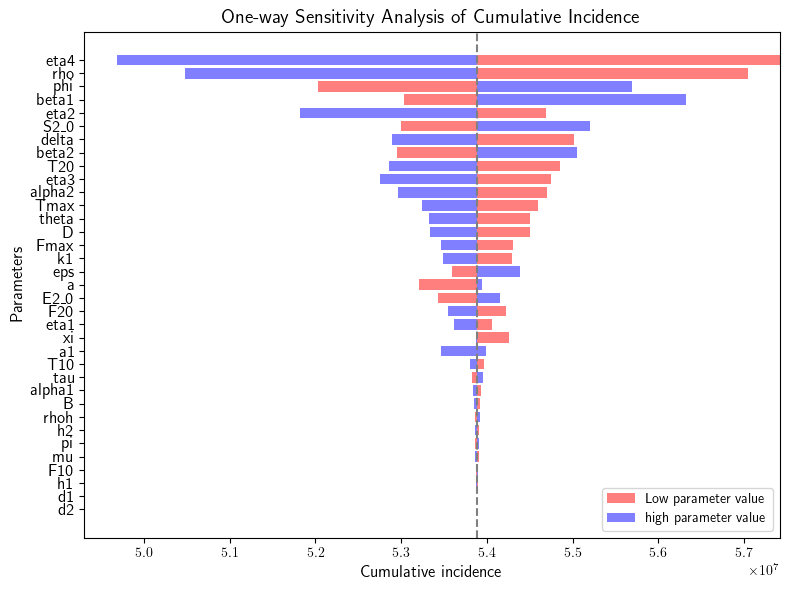

In [11]:
# Sort parameters by the magnitude of their sensitivity effect
sorted_params = sorted(sensitivity.keys(), 
                       key=lambda param: abs(sensitivity[param][1] - sensitivity[param][0]))  # optional: largest impact on top if reverse=True

# Labels, base values, and low/high values
labels = sorted_params #[param_descriptions[param] for param in sorted_params]
base_values = [Base_CI] * len(labels)
low_values = [sensitivity[param][0] for param in sorted_params]
high_values = [sensitivity[param][1] for param in sorted_params]

# Differences relative to base
low_diffs = [base - low for base, low in zip(base_values, low_values)]
high_diffs = [high - base for high, base in zip(high_values, base_values)]

# Plotting
fig, ax = plt.subplots(figsize=(8, 6))

for i, (low, high, low_diff, high_diff) in enumerate(zip(low_values, high_values, low_diffs, high_diffs)):
    # Low value bars (red)
    ax.barh(labels[i], -low_diff if low_diff < 0 else 0, left=base_values[i], color='red', alpha=0.5,label='Low parameter value' if i == 0 else "")
    ax.barh(labels[i], low_diff if low_diff > 0 else 0, left=base_values[i] + (-low_diff if low_diff < 0 else 0),color='blue', alpha=0.5)

    # High value bars (blue/red)
    ax.barh(labels[i], -high_diff if high_diff > 0 else 0, left=base_values[i], color='red', alpha=0.5)
    ax.barh(labels[i], high_diff if high_diff < 0 else 0, left=base_values[i], color='blue', alpha=0.5, label='high parameter value' if i == 0 else "")

# Base cumulative incidence line
ax.axvline(Base_CI, color='grey', linestyle='--', linewidth=1.5)

# Axis labels and title
ax.set_xlabel('Cumulative incidence', fontsize=12)
ax.set_ylabel('Parameters', fontsize=12)
ax.set_title('One-way Sensitivity Analysis of Cumulative Incidence', fontsize=14, fontweight='bold')
plt.yticks(fontsize=12)

# Legend
ax.legend(loc='lower right', fontsize=10)

# Layout and saving
plt.tight_layout()
#plt.savefig('Fig8_sensitivity_CI.pdf', bbox_inches='tight', dpi=600)
plt.show()


In [12]:
param_descriptions = {    
    'beta1': rf'Transmission rate in primary dynamics ($\beta_1$)[{diff_bounds['beta1'][0]}, {diff_bounds['beta1'][1]}]',
    'beta2': rf'Transmission rate in secondary dynamics ($\beta_2$)[{diff_bounds['beta2'][0]}, {diff_bounds['beta2'][1]}]',
    'k1': rf'Information coverage ($k$)[{diff_bounds['k1'][0]}, {diff_bounds['k1'][1]}]',
    #'a': rf'Information delay time ($\frac{1}{{a}}$ days)[{(1/(pmax*baseline_a)):.0f}, {(1/(pmin*baseline_a)):.0f}]',
    'theta': rf'Reduced reactivity for partially-immune individuals ($\theta$)[{pmin_default*params0['theta']:.2f}, {pmax_default*params0['theta']:.2f}]',
    'alpha1': rf'Prevalence prioritization by susceptible individuals ($\alpha_1$)[{pmin_default*params0['alpha1']:.2f}, {pmax_default*params0['alpha1']:.2f}]',
    'alpha2': rf'Prevalence prioritization by partially-immune individuals ($\alpha_2$)[{pmin_default*params0['alpha2']:.2f}, {pmax_default*params0['alpha2']:.2f}]',
    'delta': rf'Isolated (quarantined) proportion ($\delta$)[{diff_bounds['delta'][0]}, {diff_bounds['delta'][1]}]',
    #'F10': rf'Mandatory primary series vaccination rate  ($F_{{10}}$)[{pmin*baseline_F10:.3f}, {pmax*baseline_F10:.3f}]',
    #'F20': rf'Mandator booster vaccination rate ($F_{{20}}$)[{pmin*baseline_F20:.3f}, {pmax*baseline_F20:.3f}]',
    #'T10': rf'Mandatory testing rate in primary dynamics ($T_{{10}}$)[{pmin*baseline_T10:.3f}, {pmax*baseline_T10:.3f}]',
    'D': rf'Reactivity to prevalence information  ($D$)[{pmin_default*params0['D']:.2f}, {pmax_default*params0['D']:.2f}]',
    #'B': rf'Reactivity to severity information  ($B $)[{pmin_default*params0['B']:.2f}, {pmax_default*params0['B']:.2f}]',
    'T20': rf'Mandatory testing rate in secondary dynamics ($T_{{20}}$)[{pmin_default*params0['T20']:.2f}, {pmax_default*params0['T20']:.2f}]',
    'Tmax': rf'Maximum testing rate ($T_{{\max}}$)[{diff_bounds['Tmax'][0]}, {diff_bounds['Tmax'][1]}]',
    'Fmax': rf'Maximum vaccination rate ($F_{{\max}}$)[{pmin_default*params0['Fmax']:.2f}, {pmax_default*params0['Fmax']:.2f}]',
    'S2_0': rf'Initial immune susceptible population ($S2(0) + S3(0)$)[{0.7*NN:.0f}, {0.95*NN:.0f}]',
    'eta2': rf'Primary series vaccine effectivness after 6 months ($\eta_2$)[{diff_bounds['eta2'][0]}, {diff_bounds['eta2'][1]}]',
    'eta3': rf'Effectiveness of immunity due to prior infection after 6 months ($\eta_3$)[{diff_bounds['eta3'][0]}, {diff_bounds['eta3'][1]}]',
    'eta4': rf'Booster vaccine effectiveness ($\eta_4$)[{diff_bounds['eta4'][0]}, {diff_bounds['eta4'][1]}]',
    'rho': rf'Recovery rate for undetected and tested classes ($\rho$)[{pmin_default*params0['rho']:.2f}, {pmax_default*params0['rho']:.2f}]',
    'phi': rf'Progression rate from  primary dynamics to secondary dynamics ($\phi$)[{pmin_default*params0['phi']:.2f}, {pmax_default*params0['phi']:.2f}]',
    

}


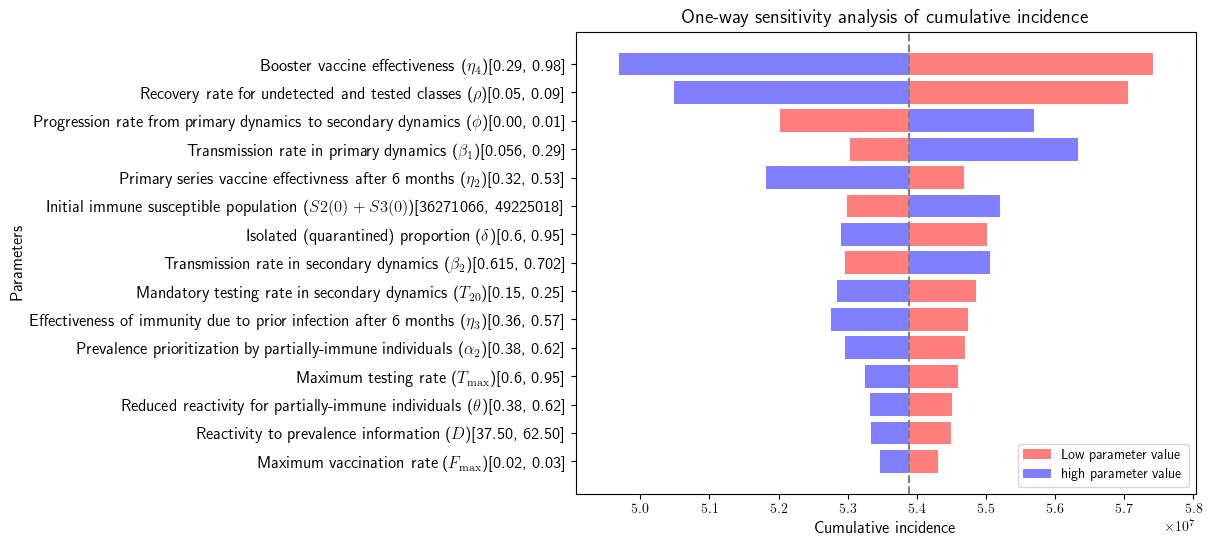

In [13]:
# Sort parameters by the magnitude of their sensitivity effect
sorted_parameters = sorted(sensitivity.keys(), 
                       key=lambda param: abs(sensitivity[param][1] - sensitivity[param][0]), reverse=True)  # optional: largest impact on top if reverse=True
top_n = 15
top_params = sorted_parameters[:top_n]
top_params = top_params[::-1]
# Labels, base values, and low/high values
labels = [param_descriptions[param] for param in top_params]
base_values = [Base_CI] * len(labels)
low_values = [sensitivity[param][0] for param in top_params]
high_values = [sensitivity[param][1] for param in top_params]

# Differences relative to base
low_diffs = [base - low for base, low in zip(base_values, low_values)]
high_diffs = [high - base for high, base in zip(high_values, base_values)]

# Plotting
fig, ax = plt.subplots(figsize=(8, 6))

for i, (low, high, low_diff, high_diff) in enumerate(zip(low_values, high_values, low_diffs, high_diffs)):
    # Low value bars (red)
    ax.barh(labels[i], -low_diff if low_diff < 0 else 0, left=base_values[i], color='red', alpha=0.5,label='Low parameter value' if i == 0 else "")
    ax.barh(labels[i], low_diff if low_diff > 0 else 0, left=base_values[i] + (-low_diff if low_diff < 0 else 0),color='blue', alpha=0.5)

    # High value bars (blue/red)
    ax.barh(labels[i], -high_diff if high_diff > 0 else 0, left=base_values[i], color='red', alpha=0.5)
    ax.barh(labels[i], high_diff if high_diff < 0 else 0, left=base_values[i], color='blue', alpha=0.5, label='high parameter value' if i == 0 else "")

# Base cumulative incidence line
ax.axvline(Base_CI, color='grey', linestyle='--', linewidth=1.5)

# Axis labels and title
ax.set_xlabel('Cumulative incidence', fontsize=12)
ax.set_ylabel('Parameters', fontsize=12)
ax.set_title('One-way sensitivity analysis of cumulative incidence', fontsize=14, fontweight='bold')
plt.yticks(fontsize=12)

# Legend
ax.legend(loc='lower right', fontsize=10)

# Layout and saving
#plt.tight_layout()
# Collect all x-extent values
xmin = min(
    min(low_values),
    min(high_values),
    Base_CI
)
xmax = max(
    max(low_values),
    max(high_values),
    Base_CI
)

# Add padding (e.g., 5–10%)
padding = 0.08 * (xmax - xmin)

ax.set_xlim(xmin - padding, xmax + padding)

plt.savefig('Fig8_sensitivity_CI1.pdf', bbox_inches='tight', dpi=600)
plt.show()

